<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/SymmetrySaddles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib

Dataset creation

In [2]:
def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

#N is batch size; D_in is input dimension;
#H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H_teacher, H_student, D_out = 1, 2, 4, 5, 1


#Create random Tensors to hold inputs and outputs, and wrap them in Variables
data = torch.Tensor(construct_dataset()) 
print(len(construct_dataset()))

1681


Models

In [3]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[1], [1], [1], [1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [4]:
class StudentNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(StudentNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [5]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
student_model = StudentNetwork(D_in, H_student, D_out)
print(student_model)

y_labels = teacher_model(data).detach()

StudentNetwork(
  (linear1): Linear(in_features=2, out_features=5, bias=False)
  (linear2): Linear(in_features=5, out_features=1, bias=False)
)


Training

In [6]:
import copy

def train(model, x, y_labels, N = 10, Ninner = 10**3, Nstart = 10,
          maxtime = 10 ** 3, nlopt_threshold = 1e-7,
          collect_history = True):
  optimizer = torch.optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                  copy.deepcopy(model.linear2.weight.data.detach().numpy())))
  for i in range(N):
    loss_tmp = []
    for j in range(Ninner):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i == 0 and (j % Nstart == 0) and j > 0:
        loss_vals.append(np.mean(loss_tmp[j - Nstart : j]))
        if collect_history:
          trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                        copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    if collect_history:
      trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                    copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    print("Iteration: %d, loss: %s" % (Ninner * i, np.mean(loss_tmp)))
    #if mean(loss_tmp) < nlopt_threshold or i == N - 1:
  return loss_vals, trace

In [7]:
loss_vals, trace = train(student_model, data, y_labels)

Iteration: 0, loss: 1.2835629432946443
Iteration: 1000, loss: 0.021371449656784534
Iteration: 2000, loss: 0.0021266729402123017
Iteration: 3000, loss: 0.001197212822851725
Iteration: 4000, loss: 0.0010991660646395758
Iteration: 5000, loss: 0.0009344646343379282
Iteration: 6000, loss: 0.0003839895397541113
Iteration: 7000, loss: 0.00010202662154915743
Iteration: 8000, loss: 7.141975983540761e-05
Iteration: 9000, loss: 5.3976609371602535e-05


Plotting

In [8]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

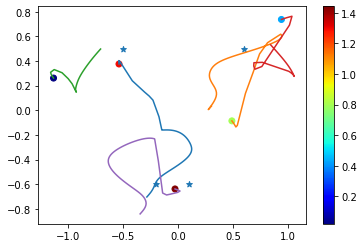

In [9]:

neuron_0_w_x = []
neuron_0_w_y = []
neuron_0_a = []

neuron_1_w_x = []
neuron_1_w_y = []
neuron_1_a = []

neuron_2_w_x = []
neuron_2_w_y = []
neuron_2_a = []

neuron_3_w_x = []
neuron_3_w_y = []
neuron_3_a = []

neuron_4_w_x = []
neuron_4_w_y = []
neuron_4_a = []

for (inp_weights, out_weights) in trace:
  neuron_0_w_x.append(inp_weights[0][0])
  neuron_0_w_y.append(inp_weights[0][1])
  neuron_0_a.append(out_weights[0][0])

  neuron_1_w_x.append(inp_weights[1][0])
  neuron_1_w_y.append(inp_weights[1][1])
  neuron_1_a.append(out_weights[0][1])

  neuron_2_w_x.append(inp_weights[2][0])
  neuron_2_w_y.append(inp_weights[2][1])
  neuron_2_a.append(out_weights[0][2])

  neuron_3_w_x.append(inp_weights[3][0])
  neuron_3_w_y.append(inp_weights[3][1])
  neuron_3_a.append(out_weights[0][3])

  neuron_4_w_x.append(inp_weights[4][0])
  neuron_4_w_y.append(inp_weights[4][1])
  neuron_4_a.append(out_weights[0][4])

plt.plot(neuron_0_w_x, neuron_0_w_y)
plt.plot(neuron_1_w_x, neuron_1_w_y)
plt.plot(neuron_2_w_x, neuron_2_w_y)
plt.plot(neuron_3_w_x, neuron_3_w_y)
plt.plot(neuron_4_w_x, neuron_4_w_y)

plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

outgoing_weights = [neuron_0_a[-1], neuron_1_a[-1], neuron_2_a[-1], neuron_3_a[-1], neuron_4_a[-1]]
plt.scatter([neuron_0_w_x[-1], neuron_1_w_x[-1], neuron_2_w_x[-1], neuron_3_w_x[-1], neuron_4_w_x[-1]],
            [neuron_0_w_y[-1], neuron_1_w_y[-1], neuron_2_w_y[-1], neuron_3_w_y[-1], neuron_4_w_y[-1]],
            c = outgoing_weights,
            cmap=matplotlib.cm.jet)
plt.colorbar()

# Teacher's neurons
#[0.6, -0.5, -0.2, 0.1],
#[0.5, 0.5, -0.6, -0.6],